# Code Associated with Research Question 1

__Research Question 1__ <br>
"Does item location on the computer screen affect the learning performance?"

In [ ]:
# common imports
import numpy as np
import os
import pickle
import json
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import zoom, gaussian_filter # smoothing
import copy
import pandas as pd

# statistics
from scipy import stats
import mne # for permutation tests

# own libraries
import neuropsy as npsy

# Set font family for all plots to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

In [ ]:
# [IMPORTANT] Set the hippocampal subfield and stimulus to be analyzed
hp_subfield                 = 'head'
stimulus                    = 'Picture Shown'
chan_label_method           = 'strict' # [IMPORTANT] change this to 'strict' or 'soft' to analyse data from strict or soft labelling

#********** PARAMETERS **********#
path_data                   = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
path_results_Q2             = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 2/Time-frequency Power Analysis - {chan_label_method} labelling (baseline -0.5 to 0 s)'
path_results_common         = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/common (baseline -0.5 to 0 s)'
path_results                = f'/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/hippocampus-{hp_subfield}-{stimulus}-{chan_label_method} labelling (baseline -0.5 to 0 s)'
subject_ids                 = npsy.utils.get_subject_ids_from_path(path_data)
postfix_save                = f'q4-{hp_subfield}-{stimulus}-{chan_label_method}'

stimulus_list               = ['Picture Shown', 'Picture Placed']
cond_column                 = 'Condition (modified)'
conditions                  = ('not learned', 'correct', 'learned-1', 'learned')
hippocampus_subfields       = ('head', 'body & tail')
dict_subfields_regex        = {'head': r'Right_HP_head|Left_HP_head', 'body & tail': r'Right_HP_body|Left_HP_body|Right_HP_tail|Left_HP_tail'}

item_groups                 = ['centre', 'middle', 'edge']
conditions_q4               = ('learned combined')


# set up directory for saving results
if not os.path.exists(path_results) or not os.path.exists(f"{path_results}/data"):
    os.makedirs(path_results)
    os.makedirs(f"{path_results}/data")
if not os.path.exists(path_results_common) or not os.path.exists(f"{path_results_common}/data"):
    os.makedirs(path_results_common)
    os.makedirs(f"{path_results_common}/data")
    
# save info file in directory
if not os.path.exists(f"{path_results}/info.txt"):
    with open(f"{path_results}/info.txt", "w") as text_file:
        text_file.write(f"Research Question 4: Does item location on the computer screen affect the learning performance?\n")
        text_file.write(f"notebook name: Q4 - location and learning performance.ipynb\n")
        text_file.write(f"Data path: {path_data}\n")
        text_file.write(f"Results path: {path_results}\n")

### Load Previous Results

- results from Q1 are loaded
- channels from hippocampus subfield are selected
- trials are assigned to the condition according to the label in the experiment dataframe (see notebook <span style="color: green;">_PRE - categorise trials.ipynb_</span>)
- a new condition is added, called _learned combined_

In [ ]:
#################### LOAD INFO DICT ####################
filename = f"{path_results_Q2}/data/1.2 tfr_analysis_info_{stimulus}.json"
with open(filename, 'r') as f:
    print(f"Loading analysis info from {repr(filename)}...")
    dict_analysis_info = json.load(f)
    print("Done")
print("Setting parameters from analysis info...")
# general
postfix_load            = dict_analysis_info['general']['post_postfix']
# analysis
tmin                    = dict_analysis_info['analysis']['tmin']
tmax                    = dict_analysis_info['analysis']['tmax']
stimulus_onset          = dict_analysis_info['analysis']['stimulus_onset']
baseline_stimulus       = dict_analysis_info['analysis']['baseline_stimulus']
baseline                = dict_analysis_info['analysis']['baseline']
baseline_method         = dict_analysis_info['analysis']['baseline_method']
# wavelet
lin_or_log              = dict_analysis_info['wavelets']['lin_or_log']
frequencies             = dict_analysis_info['wavelets']['frequencies']
cycles                  = dict_analysis_info['wavelets']['cycles']
fs                      = dict_analysis_info['wavelets']['fs']
# plot
timepoints              = dict_analysis_info['plot']['timepoints']
xticks                  = dict_analysis_info['plot']['xticks']
xlabels                 = dict_analysis_info['plot']['xlabels']
yticks                  = dict_analysis_info['plot']['yticks']
ylabels                 = dict_analysis_info['plot']['ylabels']
frequencies_plot        = dict_analysis_info['plot']['frequencies_plot']
# statistics
n_permutations          = dict_analysis_info['statistics']['n_permutations']
alpha                   = dict_analysis_info['statistics']['alpha']
# other
n_frequencies           = len(frequencies)
n_timepoints            = len(timepoints)
print("Done")


################# LOAD PERMUTATION CLUSTER MASK FROM Q1 #################
# load permutation statistics to get cluster mask
# cluster mask is the cluster found in the permutation test of the stimulus vs baseline in Q1
filename = f"2.2 {stimulus}_stat_permutation_stimulus_vs_baseline.pkl"
with open(f"{path_results_Q2}/data/{filename}", 'rb') as f:
    statistics = pickle.load(f)
# get statistics
T_obs               = statistics['T_obs']
clusters            = statistics['clusters']
cluster_p_values    = statistics['cluster_p_values']
# create cluster mask based on p-values
mask = np.full_like(T_obs, np.nan)
for cid, (c, p_val) in enumerate(zip(clusters, cluster_p_values)):
    if p_val <= alpha:
        mask[c] = T_obs[c]
    else:
        pass
# get clusters indexes (flattened shape)
idx = np.where(np.isnan(mask) == False)
# binary mask
cluster_mask_Q1                    = np.zeros_like(T_obs)
cluster_mask_Q1[idx[0], idx[1]]    = 1
cluster_mask_Q1                    = cluster_mask_Q1.astype(bool)


#################### LOAD TIME-FREQUENCY RESULTS ####################
subjects_to_remove                  = []
dict_tfr_power_results_chan_avg     = {c: {s: {} for s in subject_ids} for c in conditions}
for subject_id in subject_ids:
    print(f"\nLoading results for subject {subject_id}...")
    dict_tfr_power_results          = {c: {subject_id: {}} for c in conditions}
    
    filename = f"{path_results_Q2}/data/1.2 sub{subject_id}_tfr_power_results_{stimulus}.pkl"

    # load previously computed time-frequency power for all subjects
    load_start_time = time.time()
    with open(filename, 'rb') as f:
        dict_tfr_power_results_Q1 = pickle.load(f)
    print(f"Loading data took {time.time()-load_start_time:.2f} seconds.")
    
    
    #################### SELECT CHANNELS IN HIPPOCAMPUS SUBFIELD ####################
    select_ch_start_time = time.time()
    # load subject data (only channel dataframe)
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix=postfix_load, load_ieeg=False, load_exp=False, load_chan=True, load_targets=False, load_ied=False)
    
    # get channel names that are in the hippocampal subfield
    regex_pattern = dict_subfields_regex[hp_subfield]
    hp_subfield_chans = data.df_chan[data.df_chan['HC_Subfields'].str.contains(regex_pattern, regex=True, case=False)]['name'].tolist()
    
    # check if subject has any channels in the hippocampal subfield
    if len(hp_subfield_chans) == 0:
        subjects_to_remove.append(subject_id)
        print(f"Subject {subject_id} has no channels in the hippocampal subfield {repr(hp_subfield)}, skipping subject...")
        # skip to next subject
        continue
    else:
        # remove channels that are not in the hippocampal subfield
        for ch in list(dict_tfr_power_results_Q1[subject_id].keys()):
            if ch not in hp_subfield_chans:
                dict_tfr_power_results_Q1[subject_id].pop(ch)
    # ensure that the subject ids are updated
    print(f"Selecting channels done in {time.time()-select_ch_start_time:.2f} seconds.")
    
    
    #################### ASSIGN TRIALS TO CONDITIONS ####################
    assign_start_time = time.time()
    for condition in conditions:
        dict_tfr_power_results[condition][subject_id] = {ch: {} for ch in dict_tfr_power_results_Q1[subject_id].keys()}
        
        # load subject data (only experiment dataframe)
        data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
        data.load(load_saved=True, postfix=postfix_load, load_exp=True, load_ieeg=False, load_chan=False, load_targets=False, load_ied=False)
        
        # iterate over channels
        for ch in dict_tfr_power_results_Q1[subject_id].keys():
            # iterate over trials
            for trial in dict_tfr_power_results_Q1[subject_id][ch].keys():
                # get trial condition from experiment dataframe
                trial_condition = data.df_exp[data.df_exp['Trial Identifier'] == trial][cond_column].values[0]
                # assign trial respectively in the new dictionary  
                if trial_condition == condition:
                    dict_tfr_power_results[condition][subject_id][ch][trial] = dict_tfr_power_results_Q1[subject_id][ch][trial]          
    # clean up
    del dict_tfr_power_results_Q1
    print(f"Assigning trials to conditions done in {time.time()-assign_start_time:.2f} seconds.")
    
    
    #################### ADD CONDITION 'LEARNED COMBINED' ####################
    add_condition_start_time = time.time()
    # add new condition to the main dictionary
    channels = list(dict_tfr_power_results[conditions[0]][subject_id].keys())
    dict_tfr_power_results['learned combined'] = {}
    dict_tfr_power_results['learned combined'][subject_id] = {ch: {} for ch in channels}
    for ch in channels:
        # iterate over trials and combine the power of the two learned conditions
        # note:
        #   the keys of the two learned conditions might not be the same (if trial is excluded during analysis for either being too short, too close to the next trial, or having IEDs in the signal), 
        #   so first iterate over the keys of the first learned condition and if the key is not in the second learned condition, use the value of the first learned condition,
        #   if the key is in the second learned condition, average the power of the two learned conditions, then iterate over the keys of the second learned condition 
        #   and if the key is not in the first learned condition, use the value of the second learned condition
        #   (this is necessary as the keys of the two learned conditions might not be the same)
        #
        # get item numbers of the two learned conditions
        item_number_list_learned_1 = [v.split('-')[0] for v in dict_tfr_power_results['learned-1'][subject_id][ch].keys()]
        item_number_list_learned = [v.split('-')[0] for v in dict_tfr_power_results['learned'][subject_id][ch].keys()]
        # first iterate over trials in the learned-1 condition
        for trial in dict_tfr_power_results['learned-1'][subject_id][ch].keys():
            item_number = trial.split('-')[0]
            if item_number not in item_number_list_learned:
                # use the power of the learned-1 condition
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = dict_tfr_power_results['learned-1'][subject_id][ch][trial]
            else:
                # average the power of the two learned conditions
                trial_learned = [k for k in dict_tfr_power_results['learned'][subject_id][ch].keys() if k.split('-')[0] == item_number][0]
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = np.mean([dict_tfr_power_results['learned-1'][subject_id][ch][trial], dict_tfr_power_results['learned'][subject_id][ch][trial_learned]], axis=0)
        # add the remaining trials of the learned condition
        for trial in dict_tfr_power_results['learned'][subject_id][ch].keys():
            item_number = trial.split('-')[0]
            if item_number not in item_number_list_learned_1:
                # use the power of the learned condition
                dict_tfr_power_results['learned combined'][subject_id][ch][item_number] = dict_tfr_power_results['learned'][subject_id][ch][trial]
    print(f"Adding condition 'learned combined' done in {time.time()-add_condition_start_time:.2f} seconds.")
    

    #################### GET CHANNEL AVERAGES AS DICT ####################
    chan_average_start_time = time.time()
    tmp_conditions = conditions + ('learned combined',)
    for condition in tmp_conditions:
        # add new condition key
        if condition not in dict_tfr_power_results_chan_avg.keys():
            dict_tfr_power_results_chan_avg[condition] = {subject_id: {}}
        # add new subject key
        if subject_id not in dict_tfr_power_results_chan_avg[condition].keys():
            dict_tfr_power_results_chan_avg[condition][subject_id] = {}
            
        for ch in dict_tfr_power_results[condition][subject_id].keys():
            # if only one trial, use the power of that trial as average, otherwise average the power of all trials
            if len(dict_tfr_power_results[condition][subject_id][ch].keys()) == 1:
                print(f"Only one trial for subject {subject_id} in condition {condition} and channel {ch}.")
                dict_tfr_power_results_chan_avg[condition][subject_id][ch] = list(dict_tfr_power_results[condition][subject_id][ch].values())[0]
            else:
                dict_tfr_power_results_chan_avg[condition][subject_id][ch] = np.mean(list(dict_tfr_power_results[condition][subject_id][ch].values()), axis=0)
    print(f"Computing channel averages done in {time.time()-chan_average_start_time:.2f} seconds.")
    
    # clean up to save memory
    del dict_tfr_power_results
    
# update
conditions_extra = conditions + ('learned combined',)
subject_ids = [s for s in subject_ids if s not in subjects_to_remove]

#################### GET AVERAGES AS DICT AND (FOR SOME) ARRAY ####################
# compute subject average (average each subject across all channels)
average_start_time = time.time()
dict_tfr_power_results_subj_avg     = {c: {s: {} for s in subject_ids} for c in conditions_extra}
arr_tfr_power_results_subj_avg      = np.zeros((len(conditions_extra), len(subject_ids), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions_extra):
    for j, subject_id in enumerate(subject_ids):
        # if only one channel, use the power of that channel as average, otherwise average the power of all channels
        if len(dict_tfr_power_results_chan_avg[condition][subject_id].keys()) == 1:
            print(f"Only one channel for subject {subject_id} in condition {condition}.")
            dict_tfr_power_results_subj_avg[condition][subject_id] = list(dict_tfr_power_results_chan_avg[condition][subject_id].values())[0]
        else:
            dict_tfr_power_results_subj_avg[condition][subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[condition][subject_id].values()), axis=0)
        arr_tfr_power_results_subj_avg[i, j] = dict_tfr_power_results_subj_avg[condition][subject_id]
print(f"Computing subject averages done in {time.time()-average_start_time:.2f} seconds.")

# compute condition average (average each condition across all subjects)
average_start_time = time.time()
dict_tfr_power_results_cond_avg     = {c: {} for c in conditions_extra}
arr_tfr_power_results_cond_avg      = np.zeros((len(conditions_extra), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions_extra):
    dict_tfr_power_results_cond_avg[condition] = np.mean(list(dict_tfr_power_results_subj_avg[condition].values()), axis=0)
    arr_tfr_power_results_cond_avg[i] = dict_tfr_power_results_cond_avg[condition]
print(f"Computing condition averages done in {time.time()-average_start_time:.2f} seconds.")

Loading analysis info from '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 1/Time-frequency Power Analysis - strict labelling (baseline -0.5 to 0 s)/data/1.2 tfr_analysis_info_Picture Shown.json'...
Done
Setting parameters from analysis info...
Done

Loading results for subject 03...
Loading data took 8.73 seconds.
Selecting channels done in 0.02 seconds.
Assigning trials to conditions done in 0.54 seconds.
Adding condition 'learned combined' done in 0.06 seconds.
Computing channel averages done in 0.13 seconds.

Loading results for subject 04...
Loading data took 3.10 seconds.
Subject 04 has no channels in the hippocampal subfield 'head', skipping subject...

Loading results for subject 05...
Loading data took 6.24 seconds.
Selecting channels done in 0.01 seconds.
Assigning trials to conditions done in 0.41 seconds.
Adding condition 'learned combined' done in 0.05 seconds.
Computing channel averages done in 0.18 seconds.

Loading result

# 1. Assign Items to Groups

screen dimensions: 600 x 600 pixels

3 groups: centre, middle, edge
- centre: 0 - 100 pixels from screen centre
- middle: 100 - 200 pixels from screen centre
- edge: 200 - 300 pixels from screen centre

In [4]:
# Screen size
screen_size     = 600
half_screen     = screen_size // 2  # 300 (center in absolute coordinates)

# Square border limits (relative to the centre of the screen)
centre_limit    = 100
middle_limit    = 200
edge_limit      = 300

# Group colors
group_colors = {"centre": "dodgerblue", "middle": "forestgreen", "edge": "crimson"}

def assign_group(x, y):
    if (-centre_limit <= x <= centre_limit) and (-centre_limit <= y <= centre_limit):
        return "centre"
    elif (-middle_limit <= x <= middle_limit) and (-middle_limit <= y <= middle_limit):
        return "middle"
    elif (-edge_limit <= x <= edge_limit) and (-edge_limit <= y <= edge_limit):
        return "edge"
    else:
        print(f"Error: Item at ({x}, {y}) is not in any group.")


#################### DIVIDE ITEMS INTO GROUPS BASED ON LOCATION ON SCREEN ####################
all_image_locations = {s: None for s in subject_ids}
for subject_id in subject_ids:
    # load subject data (only experiment and targets dataframe)
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix=postfix_load, load_ieeg=False, load_exp=True, load_chan=False, load_targets=True, load_ied=False, postfix_targets="analysis")
    
    # get image coordinates
    image_locations = data.df_targets[['x_coordinate', 'y_coordinate']].values
    
    # save image coordinates for later use
    all_image_locations[subject_id] = image_locations
    
    # iterate over items and assign them to groups
    groups = [assign_group(x, y) for x, y in image_locations]
    
    # add new column to targets dataframe
    data.df_targets['Group (Location)'] = groups
    
    # add new column to experiment dataframe
    data.df_exp['Group (Location)'] = pd.Series(dtype='string')
    for item_number, group in zip(data.df_targets['picture number'], data.df_targets['Group (Location)']):
        # get all rows in experiment dataframe that correspond to the item number (i.e. all trials of the item)
        # and assign the group label to the group column
        pattern = fr'^{item_number}-\d{{1,2}}'
        data.df_exp.loc[data.df_exp['Trial Identifier'].str.contains(pattern, regex=True, case=False), 'Group (Location)'] = group
    
    # save dataframes with new 'Group (Location)' column
    data.save(save_exp=True, save_targets=True, save_ieeg=False, save_chan=False, save_ied=False, postfix=postfix_save)


    #################### PLOT GROUP BORDERS AND ITEMS FOR SUBJECT ####################
    # Map groups to colors
    colors = [group_colors[g] for g in data.df_targets['Group (Location)']]

    # Convert relative coordinates to absolute for plotting
    absolute_positions = image_locations + half_screen

    # Create the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw square boundaries (absolute coordinates)
    square_centre = plt.Rectangle((half_screen - centre_limit, half_screen - centre_limit), 
                                2 * centre_limit, 2 * centre_limit, fill=False, 
                                color="black", linestyle="dashed", label="Centre Border")
    square_middle = plt.Rectangle((half_screen - middle_limit, half_screen - middle_limit), 
                                2 * middle_limit, 2 * middle_limit, fill=False, 
                                color="black", linestyle="dashed", label="Middle Border")

    # Add squares to the plot
    ax.add_patch(square_centre)
    ax.add_patch(square_middle)

    # Scatter plot for image locations (in absolute coordinates)
    ax.scatter(absolute_positions[:, 0], absolute_positions[:, 1], c=colors)

    # Formatting the plot
    ax.set_xlim(0, screen_size)
    ax.set_ylim(0, screen_size)

    # Adjust tick labels to show relative coordinates
    tick_positions = np.linspace(0, screen_size, num=7)  # 7 ticks from 0 to 600
    tick_labels = np.linspace(-half_screen, half_screen, num=7, dtype=int)  # Convert to relative values
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)

    # Labels and title
    ax.set_xlabel("X Coordinate (relative to centre)")
    ax.set_ylabel("Y Coordinate (relative to centre)")
    ax.set_title(f"Participant {subject_id}: Item Groups")
    ax.set_aspect('equal')  # Keep aspect ratio square
    
    # save figure
    fig.savefig(f"{path_results_common}/1. sub{subject_id}_item_groups.png", dpi=300, bbox_inches='tight')
    plt.close(fig)
    # plt.show()
    
    
#################### PLOT GROUP BORDERS AND ITEMS FOR ALL SUBJECTS ####################
# Create the figure
fig, ax = plt.subplots(figsize=(6, 6))

# Draw square boundaries (absolute coordinates)
square_centre = plt.Rectangle((half_screen - centre_limit, half_screen - centre_limit), 
                            2 * centre_limit, 2 * centre_limit, fill=False, 
                            color="black", linestyle="dashed", label="Centre Border")
square_middle = plt.Rectangle((half_screen - middle_limit, half_screen - middle_limit), 
                            2 * middle_limit, 2 * middle_limit, fill=False, 
                            color="black", linestyle="dashed", label="Middle Border")

# Add squares to the plot
ax.add_patch(square_centre)
ax.add_patch(square_middle)

for subject_id in subject_ids:
    image_locations = all_image_locations[subject_id]
    groups = [assign_group(x, y) for x, y in image_locations]
    
    # Map groups to colors
    colors = [group_colors[g] for g in groups]
    
    # Convert relative coordinates to absolute for plotting
    absolute_positions = image_locations + half_screen
    
    # Scatter plot for image locations (in absolute coordinates)
    ax.scatter(absolute_positions[:, 0], absolute_positions[:, 1], c=colors)

# Formatting the plot
ax.set_xlim(0, screen_size)
ax.set_ylim(0, screen_size)

# Adjust tick labels to show relative coordinates
tick_positions = np.linspace(0, screen_size, num=7)  # 7 ticks from 0 to 600
tick_labels = np.linspace(-half_screen, half_screen, num=7, dtype=int)  # Convert to relative values
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Labels and title
ax.set_xlabel("X Coordinate (relative to centre)", fontsize=12)
ax.set_ylabel("Y Coordinate (relative to centre)", fontsize=12)
# ax.set_title(f"Item Groups for all Participants", fontsize=12)
ax.set_aspect('equal')  # Keep aspect ratio square

# save figure
fig.savefig(f"{path_results_common}/1. all_subjects_item_groups.png", dpi=300, bbox_inches='tight')
plt.close(fig)
# plt.show()

### 1.1 Number of Items in Each Group Per Subject

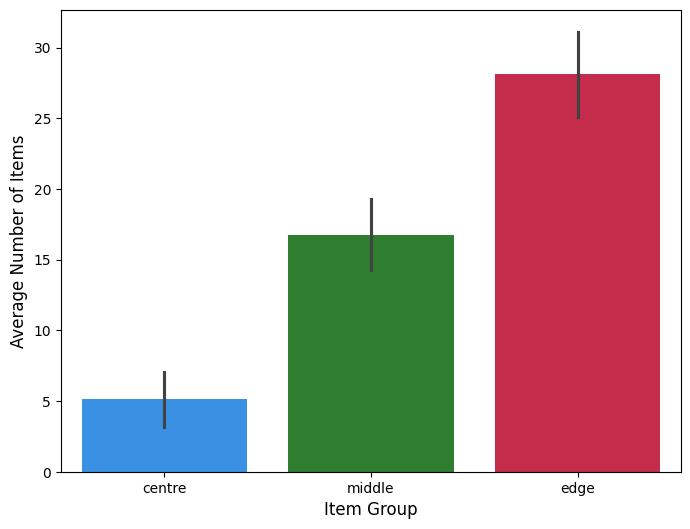

In [5]:
df_group_counts = pd.DataFrame(columns=item_groups, index=subject_ids)
for subject_id in subject_ids:
    # find groups
    image_locations = all_image_locations[subject_id]
    groups = [assign_group(x, y) for x, y in image_locations]
    
    # add to dataframe
    df_group_counts.loc[subject_id] = [groups.count(g) for g in item_groups]
    
df_group_counts.to_csv(f"{path_results_common}/data/1.1 all_subjects_item_group_counts.csv")

# seaborn bar plot for group counts
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=df_group_counts, ax=ax, errorbar="sd", palette=group_colors)
ax.set_xlabel("Item Group", fontsize=12)
ax.set_ylabel("Average Number of Items", fontsize=12)
# ax.set_title("Item Group Counts for all Participants")
fig.savefig(f"{path_results_common}/1.1 all_subjects_item_group_counts.png", dpi=300, bbox_inches='tight')
# plt.close(fig)
plt.show()

# 2. t-test of Window-of-Interest

- one hippocampal subfield (_head_ or _body & tail_)
- one stimulus (_picture shown_ or _picture placed_)
- one condition: _learned combined_
- three item groups: _centre_, _middle_, and _edge_

### 2.0 Helper Functions

In [6]:
def find_freq_indices(frequencies, freq_start, freq_end):
    """find_freq_indices Find the frequency indices for a specific range given in Hz.
    
    The function will take the closest frequency values to the given range.

    Args:
        frequencies (1darray): The frequency values in Hz.
        freq_start (float): The start frequency of the range in Hz.
        freq_end (float): The end frequency of the range in Hz.

    Returns:
        freq_start_idx (int): The start frequency index of the range.
        freq_end_idx (int): The end frequency index of the range.
    """
    frequencies = np.array(frequencies)
    # find the closest frequency values to the given range
    freq_start_closest = min(frequencies, key=lambda x:abs(x-freq_start))
    freq_end_closest = min(frequencies, key=lambda x:abs(x-freq_end))
    # convert frequency range to indices
    freq_start_idx = np.where(frequencies == freq_start_closest)[0][0].astype(int)
    freq_end_idx = np.where(frequencies == freq_end_closest)[0][0].astype(int) + 1
    return freq_start_idx, freq_end_idx

def find_time_indices(stimulus_onset, fs, time_start, time_end):
    """find_time_indices Find the time indices for a specific range.

    Args:
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        time_start (float): The start time of the range in seconds.
        time_end (float): The end time of the range in seconds.

    Returns:
        time_start_idx (int): The start time index of the range.
        time_end_idx (int): The end time index of the range.
    """
    # convert time range to indices with respect to the stimulus onset
    time_start_idx = np.floor(stimulus_onset + (time_start * fs)).astype(int)
    time_start_idx = 0 if time_start_idx < 0 else time_start_idx
    time_end_idx = np.floor(stimulus_onset + (time_end * fs)).astype(int)
    return time_start_idx, time_end_idx

def cut_tfr_data(tfr_data, freq_start_idx=None, freq_end_idx=None, time_start_idx=None, time_end_idx=None, cluster_mask=None):
    """cut_tfr_data Cut time-frequency power data for a specific time-frequency range and average the power in the area.

    Args:
        tfr_data (2darray): Time-frequency power data to cut.
        freq_start_idx (int, optional): The start frequency index of the range. Defaults to None.
        freq_end_idx (int, optional): The end frequency index of the range. Defaults to None.
        time_start_idx (int, optional): The start time index of the range. Defaults to None.
        time_end_idx (int, optional): The end time index of the range. Defaults to None.
        cluster_mask (2darray, optional): The cluster mask to cut the time-frequency power data. Defaults to None.

    Returns:
        tfr_data_cut (float): The average time-frequency power data for the specified range.
    """
    # cut time-frequency power data and average flattened array
    if cluster_mask is not None:
        tfr_data_cut = tfr_data[cluster_mask].mean()
    else:
        tfr_data_cut = np.mean(tfr_data[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx], axis=None)
    return tfr_data_cut

def barplot_annotate_brackets(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    
    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)
    

def compute_standard_error(tfr_data_subjects_avg, subject_ids, freq_start_idx=None, freq_end_idx=None, time_start_idx=None, time_end_idx=None, cluster_mask=None):
    """compute_standard_error Computes the standard error for each condition across subjects.

    Args:
        tfr_data_subjects_avg (dict): A dictionary containing the time-frequency power data for all subjects.
        subject_ids (list): A list of all subjects.
        freq_start_idx (int, optional): The start frequency index of the range to cut the time-frequency power data. Defaults to None.
        freq_end_idx (int, optional): The end frequency index of the range to cut the time-frequency power data. Defaults to None.
        time_start_idx (int, optional): The start time index of the range to cut the time-frequency power data. Defaults to None.
        time_end_idx (int, optional): The end time index of the range to cut the time-frequency power data. Defaults to None.
        cluster_mask (2darray, optional): The cluster mask to cut the time-frequency power data. Defaults to None.

    Returns:
        stderror (dict): A dict containing the standard error for each condition.
    """
    means = []
    for i, sub_id in enumerate(subject_ids):
        # cut time-frequency power data for each subject and average flattened array
        # check if tfr_data_subjects_avg is array
        if isinstance(tfr_data_subjects_avg, np.ndarray):
            tfr_data_window_avg = cut_tfr_data(tfr_data_subjects_avg[i], freq_start_idx, freq_end_idx, time_start_idx, time_end_idx, cluster_mask)
        else:
            tfr_data_window_avg = cut_tfr_data(tfr_data_subjects_avg[sub_id], freq_start_idx, freq_end_idx, time_start_idx, time_end_idx, cluster_mask)
        means.append(tfr_data_window_avg)
    # compute standard error
    stderror = np.std(means, axis=0) / np.sqrt(len(means))
    return stderror


def get_all_subjects_cut_data(tfr_data_subjects_avg, subject_ids, condition, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """get_all_subjects_cut_data Get time-frequency power data for all subjects individually in a condition.

    Args:
        tfr_data_subjects_avg (dict): A dictionary containing the time-frequency power data for each subject.
        subject_ids (list): A list of subject ids to get the time-frequency power data for.
        condition (str): The condition to get the time-frequency power data for.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data.
        freq_end (float): The end frequency of the range to cut the time-frequency power data.
        time_start (float): The start time of the range to cut the time-frequency power data.
        time_end (float): The end time of the range to cut the time-frequency power data.

    Returns:
        dict: A dictionary containing the time-frequency power data for all subjects in a condition.
    """    
    tfr_data_cut_subs = {s: None for s in subject_ids}
    
    for sub_id in subject_ids:
        # cut time-frequency power data for each subject and average flattened array
        tfr_data_cut_subs[sub_id], _, _, _, _ = cut_tfr_data(tfr_data_subjects_avg[condition][sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)

    return tfr_data_cut_subs


def load_results(filename, subject_ids):
    
    # initialise
    dict_tfr_power_results_chan_avg     = {s: {} for s in subject_ids}
    dict_tfr_power_results_subj_avg     = {s: {} for s in subject_ids}
    arr_tfr_power_results_total_avg     = None
    
    # load data for each subject
    for subject_id in subject_ids:
        filename = f"{path_results}/data/1.2 sub{subject_id}_tfr_power_results_{stimulus}.pkl"

        # load previously computed time-frequency power for all subjects
        with open(filename, 'rb') as f:
            dict_tfr_power_results = pickle.load(f)

    # # get conditions and subject ids from the loaded results dictionary
    # subject_ids = list(dict_tfr_power_results.keys())

    #################### GET AVERAGES AS DICT ####################
    # compute channel average (average each channel across all trials)
    # for subject_id in subject_ids:
        for ch in dict_tfr_power_results[subject_id].keys():
            dict_tfr_power_results_chan_avg[subject_id][ch] = np.mean(list(dict_tfr_power_results[subject_id][ch].values()), axis=0)
            
        # clean up to save memory
        del dict_tfr_power_results
                
    # compute subject average (average each subject across all channels)
    for subject_id in subject_ids:
        dict_tfr_power_results_subj_avg[subject_id] = np.mean(list(dict_tfr_power_results_chan_avg[subject_id].values()), axis=0)
        
    #################### GET AVERAGES AS ARRAY ####################
    # compute total average (average across all subjects)
    arr_tfr_power_results_total_avg = np.mean(list(dict_tfr_power_results_subj_avg.values()), axis=0)
    # get time-frequency shape
    n_frequencies   = arr_tfr_power_results_total_avg.shape[0]
    n_timepoints    = arr_tfr_power_results_total_avg.shape[1]
    # create array for subject averages
    arr_tfr_power_results_subj_avg                  = np.zeros((len(subject_ids), n_frequencies, n_timepoints))
    for i, subject_id in enumerate(subject_ids):
        arr_tfr_power_results_subj_avg[i]           = dict_tfr_power_results_subj_avg[subject_id]
    
    return arr_tfr_power_results_total_avg, arr_tfr_power_results_subj_avg

In [32]:
def cut_tfr_data(tfr_data, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """cut_tfr_data Cut time-frequency power data for a specific time-frequency range and average area.

    Args:
        tfr_data (2darray): Time-frequency power data to cut.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data in Hz.
        freq_end (float): The end frequency of the range to cut the time-frequency power data in Hz.
        time_start (float): The start time of the range to cut the time-frequency power data in seconds.
        time_end (float): The end time of the range to cut the time-frequency power data in seconds.

    Returns:
        tfr_data_cut (float): The average time-frequency power data for the specified range.
        freq_start_idx (int): The start frequency index of the range.
        freq_end_idx (int): The end frequency index of the range.
        time_start_idx (int): The start time index of the range.
        time_end_idx (int): The end time index of the range.
    """    
    # convert frequency range to indices
    freq_start_idx = np.where(frequencies == freq_start)[0][0].astype(int)
    freq_end_idx = np.where(frequencies == freq_end)[0][0].astype(int) + 1

    # convert time range to indices with respect to the stimulus onset
    time_start_idx = np.floor(stimulus_onset + (time_start * fs)).astype(int)
    time_start_idx = 0 if time_start_idx < 0 else time_start_idx
    time_end_idx = np.floor(stimulus_onset + (time_end * fs)).astype(int)
    
    # cut time-frequency power data and average flattened array
    tfr_data_cut = np.mean(tfr_data[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx], axis=None)
    return tfr_data_cut, freq_start_idx, freq_end_idx, time_start_idx, time_end_idx

def barplot_annotate_brackets(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    
    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)
    

def compute_standard_error(tfr_data_subs_avg, subject_ids, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """compute_standard_error Computes the standard error for each condition across subjects.

    Args:
        tfr_data_subs_avg (dict): A dictionary containing the time-frequency power data for all subjects.
        subject_ids (list): A list of all subjects.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data.
        freq_end (float): The end frequency of the range to cut the time-frequency power data.
        time_start (float): The start time of the range to cut the time-frequency power data.
        time_end (float): The end time of the range to cut the time-frequency power data.

    Returns:
        stderror (dict): A dict containing the standard error for each condition.
    """
    # general solution, but fix for when groups of subjects do not match
    if subject_ids is None:
        subject_ids = list(tfr_data_subs_avg.keys())
    
    means = []
    for i, sub_id in enumerate(subject_ids):
        # cut time-frequency power data for each subject and average flattened array
        # check if tfr_data_subs_avg is array
        if isinstance(tfr_data_subs_avg, np.ndarray):
            tfr_data_window_avg, _, _, _, _ = cut_tfr_data(tfr_data_subs_avg[i], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
        else:
            tfr_data_window_avg, _, _, _, _ = cut_tfr_data(tfr_data_subs_avg[sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
        means.append(tfr_data_window_avg)
    # compute standard error
    stderror = np.std(means, axis=0) / np.sqrt(len(means))
    return stderror


def get_all_subjects_cut_data(tfr_data_subjects_avg, subject_ids, condition, stimulus_onset, fs, freq_start, freq_end, time_start, time_end):
    """get_all_subjects_cut_data Get time-frequency power data for all subjects individually in a condition.

    Args:
        tfr_data_subjects_avg (dict): A dictionary containing the time-frequency power data for each subject.
        subject_ids (list): A list of subject ids to get the time-frequency power data for.
        condition (str): The condition to get the time-frequency power data for.
        stimulus_onset (int): The stimulus onset time in time points.
        fs (int): The sampling frequency in Hz.
        freq_start (float): The start frequency of the range to cut the time-frequency power data.
        freq_end (float): The end frequency of the range to cut the time-frequency power data.
        time_start (float): The start time of the range to cut the time-frequency power data.
        time_end (float): The end time of the range to cut the time-frequency power data.

    Returns:
        dict: A dictionary containing the time-frequency power data for all subjects in a condition.
    """    
    # general solution, but fix for when groups of subjects do not match
    if subject_ids is None:
        subject_ids = list(tfr_data_subjects_avg.keys())
    tfr_data_cut_subs = {s: None for s in subject_ids}
        
    if condition is None:
        for sub_id in subject_ids:
            # cut time-frequency power data for each subject and average flattened array
            tfr_data_cut_subs[sub_id], _, _, _, _ = cut_tfr_data(tfr_data_subjects_avg[sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
    else:
        for sub_id in subject_ids:
            # cut time-frequency power data for each subject and average flattened array
            tfr_data_cut_subs[sub_id], _, _, _, _ = cut_tfr_data(tfr_data_subjects_avg[condition][sub_id], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)

    return tfr_data_cut_subs

### 2.1 Divide results into groups

In [7]:
# initialise dictionary with the same structure as the original dictionary but with added item groups
dict_tfr_power_results_item_groups = {c: {g: {s: {} for s in subject_ids} for g in item_groups} for c in conditions}
for condition in conditions:
    for group in item_groups:
        for subject_id in subject_ids:
            dict_tfr_power_results_item_groups[condition][group][subject_id] = {ch: {} for ch in dict_tfr_power_results[condition][subject_id].keys()}


#################### DIVIDE RESULTS INTO ITEM LOCATION GROUPS ####################
divide_start_time = time.time()
for condition in conditions:
    for group in item_groups:
        for subject_id in subject_ids:
            dict_tfr_power_results_item_groups[condition][group][subject_id] = {ch: {} for ch in dict_tfr_power_results[condition][subject_id].keys()}
            
            # load subject data (experiment and targets dataframes)
            data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
            data.load(load_saved=True, postfix=postfix_load, load_ieeg=False, load_exp=True, load_chan=False, load_targets=True, load_ied=False)
            
            # iterate over channels
            for ch in dict_tfr_power_results[condition][subject_id].keys():
                
                if dict_tfr_power_results[condition][subject_id][ch] is None:
                    print(f"Subject {subject_id} has no data for channel {repr(ch)}.")
                    continue
                
                # iterate over trials
                for trial in dict_tfr_power_results[condition][subject_id][ch].keys():
                    # trial identifier is different for the learned combined condition (only contains the item number)
                    
                    if dict_tfr_power_results[condition][subject_id][ch][trial] is None:
                        print(f"Subject {subject_id} has no data for trial {repr(trial)}.")
                        
                    if condition != 'learned combined':
                        
                        # get trial condition from experiment dataframe
                        trial_condition = data.df_exp[data.df_exp['Trial Identifier'] == trial][cond_column].values[0]
                        # get trial image location group from experiment dataframe
                        trial_group = data.df_exp[data.df_exp['Trial Identifier'] == trial]['Group (Location)'].values[0]
                        # assign trial respectively in the new dictionary
                        if trial_condition == condition:
                            dict_tfr_power_results_item_groups[condition][trial_group][subject_id][ch][trial] = dict_tfr_power_results[condition][subject_id][ch][trial]
                        
                    elif condition == 'learned combined':
                        # get trial image location group from targets dataframe
                        trial_group = data.df_targets[data.df_targets['picture number'] == int(trial)]['Group (Location)'].values[0]
                        # assign trial respectively in the new dictionary
                        dict_tfr_power_results_item_groups[condition][trial_group][subject_id][ch][trial] = dict_tfr_power_results[condition][subject_id][ch][trial]
                        
# check if there are empty values in any keys in dictionary after division
for i in range(5): # 5 iterations of checking for empty values
    print(f"Iteration {i+1}")
    remove_keys = []
    for condition in dict_tfr_power_results_item_groups.keys():
        if len(dict_tfr_power_results_item_groups[condition].keys()) == 0:
            print(f"ERROR: Condition {repr(condition)} has no data.")
            continue
        
        for group in dict_tfr_power_results_item_groups[condition].keys():
            if len(dict_tfr_power_results_item_groups[condition][group].keys()) == 0:
                print(f"ERROR: Condition: {repr(condition)}, Group {repr(group)} has no data.")
                continue
            
            for subject_id in dict_tfr_power_results_item_groups[condition][group].keys():
                if len(dict_tfr_power_results_item_groups[condition][group][subject_id].keys()) == 0:
                    print(f"MISSING: Condition: {repr(condition)}, Group {repr(group)}, Subject {repr(subject_id)} has no data.")
                    remove_keys.append((condition, group, subject_id))
                    continue
                
                for ch in dict_tfr_power_results_item_groups[condition][group][subject_id].keys():
                    if len(dict_tfr_power_results_item_groups[condition][group][subject_id][ch].keys()) == 0:
                        print(f"MISSING: Condition: {repr(condition)}, Group {repr(group)}, Subject {repr(subject_id)}, Channel {repr(ch)} has no data.")
                        remove_keys.append((condition, group, subject_id, ch))
                        continue
                    
    for keys in remove_keys:
        if len(keys) == 3:
            dict_tfr_power_results_item_groups[keys[0]][keys[1]].pop(keys[2])
            print(f"REMOVED: Condition: {repr(keys[0])}, Group {repr(keys[1])}, Subject {repr(keys[2])} removed.")
        elif len(keys) == 4:
            dict_tfr_power_results_item_groups[keys[0]][keys[1]][keys[2]].pop(keys[3])
            print(f"REMOVED: Condition: {repr(keys[0])}, Group {repr(keys[1])}, Subject {repr(keys[2])}, Channel {repr(keys[3])} removed.")
            
# update subject ids
# subject_ids = list(dict_tfr_power_results_item_groups['correct']['centre'].keys())
print(f"Dividing results into item location groups done in {time.time()-divide_start_time:.2f} seconds.")
                        
                        
#################### GET AVERAGES AS DICT AND (FOR SOME) ARRAY ####################
average_start_time = time.time()
# compute channel average (average each channel across all trials)
dict_tfr_power_results_item_groups_chan_avg = {c: {g: {s: {} for s in dict_tfr_power_results_item_groups[c][g].keys()} for g in item_groups} for c in conditions}
for condition in conditions:
    for group in item_groups:
        for subject_id in dict_tfr_power_results_item_groups[condition][group].keys():
            for ch in dict_tfr_power_results_item_groups[condition][group][subject_id].keys():
                # if no trials, skip (because trials have been excluded during time-frequency power analysis)
                if len(dict_tfr_power_results_item_groups[condition][group][subject_id][ch].keys()) == 0:
                    continue
                # if only one trial, use the trial power, otherwise the np.mean function will take the average across the wrong axis
                elif len(dict_tfr_power_results_item_groups[condition][group][subject_id][ch].keys()) == 1:
                    dict_tfr_power_results_item_groups_chan_avg[condition][group][subject_id][ch] = list(dict_tfr_power_results_item_groups[condition][group][subject_id][ch].values())[0]
                else:
                    dict_tfr_power_results_item_groups_chan_avg[condition][group][subject_id][ch] = np.mean(list(dict_tfr_power_results_item_groups[condition][group][subject_id][ch].values()), axis=0)
                
# compute subject average (average each subject across all channels)
dict_tfr_power_results_item_groups_subj_avg = {c: {g: {} for g in item_groups} for c in conditions}
arr_tfr_power_results_item_groups_subj_avg = np.zeros((len(conditions), len(item_groups), len(subject_ids), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    for j, group in enumerate(item_groups):
        for k, subject_id in enumerate(dict_tfr_power_results_item_groups[condition][group].keys()):
            # if only one channel, use the channel average, otherwise the np.mean function will take the average across the wrong axis 
            if len(dict_tfr_power_results_item_groups[condition][group][subject_id].keys()) == 1:
                dict_tfr_power_results_item_groups_subj_avg[condition][group][subject_id] = list(dict_tfr_power_results_item_groups_chan_avg[condition][group][subject_id].values())[0]
            else:
                dict_tfr_power_results_item_groups_subj_avg[condition][group][subject_id] = np.mean(list(dict_tfr_power_results_item_groups_chan_avg[condition][group][subject_id].values()), axis=0)

            # [REMOVE] cannot create array of including all subjects as the groups have different shapes
            # arr_tfr_power_results_item_groups_subj_avg[i, j, k] = dict_tfr_power_results_item_groups_subj_avg[condition][group][subject_id]
            
# compute condition average (average each condition across all subjects)
dict_tfr_power_results_item_groups_cond_avg = {c: {} for c in conditions}
arr_tfr_power_results_item_groups_cond_avg = np.zeros((len(conditions), len(item_groups), n_frequencies, n_timepoints))
for i, condition in enumerate(conditions):
    for j, group in enumerate(item_groups):
        dict_tfr_power_results_item_groups_cond_avg[condition][group] = np.mean(list(dict_tfr_power_results_item_groups_subj_avg[condition][group].values()), axis=0)
        arr_tfr_power_results_item_groups_cond_avg[i, j] = dict_tfr_power_results_item_groups_cond_avg[condition][group]
print(f"Computing averages done in {time.time()-average_start_time:.2f} seconds.")

NameError: name 'dict_tfr_power_results' is not defined

### 2.2 Cut Window-of-Interest

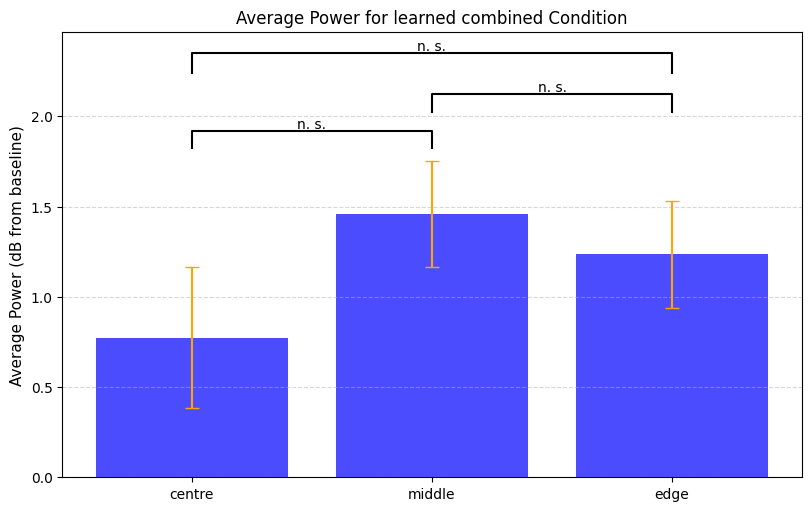

In [ ]:
# [IMPORTANT] Change parameters as needed
freq_start, freq_end    = 3, 6      # frequency range to cut (in Hz)
time_start, time_end    = 0.25, 0.6   # time range to cut (in seconds)
bool_save               = False

# parameters
groups_compare          = ['centre', 'middle', 'edge']
condition               = 'learned combined'
stimulus_onset          = 255
fs                      = 512

# statistical test parameters
alpha                   = 0.05
ttest_pairs             = [('centre', 'middle'), ('centre', 'edge'), ('middle', 'edge')]

# ********** CUT WINDOW-OF-INTEREST ********** #
tfr_data_cut_groups     = {f'{group}': None for group in groups_compare}
tfr_data_cut_subs       = {f'{group}': {sub_id: None for sub_id in dict_tfr_power_results_item_groups_subj_avg[condition][group]} for group in groups_compare}

# cut data for each group
for group in groups_compare:
    # cut data for each group
    tfr_data_cut_groups[group], freq_start_idx, freq_end_idx, time_start_idx, time_end_idx = cut_tfr_data(
        arr_tfr_power_results_item_groups_cond_avg[conditions.index(condition)][groups_compare.index(group)], stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
    
    # cut data for each subject in the group
    tfr_data_cut_subs[group] = get_all_subjects_cut_data(dict_tfr_power_results_item_groups_subj_avg[condition][group], None, None, stimulus_onset, fs, freq_start, freq_end, time_start, time_end)


# ********** COMPUTE T-TEST ********** #
ttest_results = {}
for pair_a, pair_b in ttest_pairs:
    # get the subject average data for the two conditions
    sa = np.array([tfr_data_cut_subs[pair_a][sub_id] for sub_id in tfr_data_cut_subs[pair_a].keys()])
    sb = np.array([tfr_data_cut_subs[pair_b][sub_id] for sub_id in tfr_data_cut_subs[pair_b].keys()])
    # perform paired t-test
    ttest_results[f'{pair_a} and {pair_b}'] = stats.ttest_rel(a=sa, b=sb, nan_policy='raise', alternative='two-sided', axis=0)
    
    
# ********** BAR PLOT ********** #
stderror = {f'{group}': None for group in groups_compare}
for group in groups_compare:
    stderror[group] = compute_standard_error(dict_tfr_power_results_item_groups_subj_avg[condition][group], None, stimulus_onset, fs, freq_start, freq_end, time_start, time_end)
se          = [stderror[g] for g in groups_compare]
bars        = groups_compare
heights     = [tfr_data_cut_groups[g] for g in groups_compare]

# create figure
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
ax.bar(
    bars, 
    heights, 
    yerr=se, 
    capsize=5, 
    color='blue',
    ecolor='orange',
    alpha=0.7)
ax.set_ylabel("Average Power (dB from baseline)", fontsize=11)
ax.set_title(f'Average Power for {condition} Condition')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# add significance brackets
significant_strings = {f'{pair_a} and {pair_b}': None for pair_a, pair_b in ttest_pairs}
for (pair_a, pair_b) in ttest_pairs:
    p = ttest_results[f'{pair_a} and {pair_b}'].pvalue
    if p < alpha:
        significant_strings[f'{pair_a} and {pair_b}'] = f"p < {alpha}"
    else:
        significant_strings[f'{pair_a} and {pair_b}'] = f"n. s. (p = {p:.3f})"
barplot_annotate_brackets(ax, 0, 1, significant_strings["centre and middle"], np.arange(len(bars)), heights, fs=10, dh=0.2) # centre and middle
barplot_annotate_brackets(ax, 1, 2, significant_strings["middle and edge"], np.arange(len(bars)), heights, fs=10, dh=0.28) # middle and edge
barplot_annotate_brackets(ax, 0, 2, significant_strings["centre and edge"], np.arange(len(bars)), heights, fs=10, dh=0.45) # centre and edge

# save figure
fig.savefig(f"{path_results}/2.2 {stimulus}_window-of-interest_groups_t_test___{freq_start}-{freq_end}_Hz___{time_start}-{time_end}_s___.png", dpi=300, bbox_inches='tight')

plt.show()

In [87]:
ttest_results

{'centre and middle': TtestResult(statistic=-1.3243279572001212, pvalue=0.21803781852117482, df=9),
 'centre and edge': TtestResult(statistic=-0.8854870795536076, pvalue=0.39893424829333113, df=9),
 'middle and edge': TtestResult(statistic=1.2764467553429832, pvalue=0.2337494071469986, df=9)}

# 3. Number of Trials Needed to Learn in Each Group

- count the number of trials used by each participant for each item
- assign count to the respective item location group
- conduct a chi-squared test to test if the frequency of trials in each group is significantly different

In [24]:
# ********** COUNT NUMBER OF TRIALS PER ITEM IN GROUP PER SUBJECT ********** #
df = pd.DataFrame(columns=['Subject ID', 'Item Number', 'Group', 'Number of Trials'])
dict_group_trial_count = {group: [] for group in item_groups}
for subject_id in subject_ids:
    # load subject data (only experiment and targets dataframes)
    data = npsy.DataHandler(path=path_data, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix=postfix_save, load_ieeg=False, load_exp=True, load_chan=False, load_targets=True, load_ied=False)
    
    for item in data.df_targets['picture number']:
        # count the number of trials for each item
        count = data.df_exp[data.df_exp['Trial Identifier'].str.contains(fr'^{item}-\d{{1,2}}', regex=True, case=False)].shape[0]
        # get the group of the item
        group = data.df_targets[data.df_targets['picture number'] == item]['Group (Location)'].values[0]
        # create a temporary pandas dataframe to concatenate with the full dataframe
        df_tmp = pd.DataFrame([[subject_id, item, group, count]], columns=df.columns)
        # append values to the dataframe
        df = pd.concat([df if not df.empty else None, df_tmp], ignore_index=True)
        
        
# ********** PEARSON'S CHI SQUARE TEST ********** #
f_obs = df.pivot_table(index='Group', columns='Subject ID', values='Number of Trials', aggfunc='mean').values
res = stats.chi2_contingency(f_obs)
print(f"Chi-square statistic:\t{res.statistic:.2f}")
print(f"p-value:\t\t{res.pvalue:.2f}")
print(f"Degrees of freedom:\t{res.dof}")
print("Expected frequencies:")
print(res.expected_freq)

# save dataframes to csv
df.to_csv(f"{path_results}/data/2.2 item_group_trial_counts.csv")
df = df.pivot_table(index='Group', columns='Subject ID', values='Number of Trials', aggfunc='mean')
df.to_csv(f"{path_results}/data/2.2 item_group_trial_counts_mean.csv")

Chi-square statistic:	5.64
p-value:		1.00
Degrees of freedom:	20
Expected frequencies:
[[4.4459727  5.00119572 3.1411393  8.56996537 6.70903306 4.40984564
  6.94695902 8.02896325 4.4724891  7.98391419 6.7929036 ]
 [3.66883293 4.12700499 2.59207964 7.07196676 5.53631861 3.63902074
  5.73265598 6.62552983 3.69071436 6.58835518 5.60552889]
 [3.93830792 4.43013262 2.78246733 7.5914012  5.94296002 3.90630604
  6.15371833 7.11217358 3.96179654 7.07226845 6.01725378]]


In [25]:
df

Subject ID,03,04,05,07,09,10,11,12,14,15,19
Group,,,,,,,,,,,
centre,4.142857,4.750000,3.333333,5.833333,6.142857,4.500000,8.000000,10.000000,3.000,9.800000,7.000000
edge,3.833333,4.433333,2.300000,8.900000,6.045455,3.655172,5.500000,5.766667,4.125,3.785714,6.533333
middle,4.076923,4.375000,2.882353,8.500000,6.000000,3.800000,5.333333,6.000000,5.000,8.058824,4.882353
